# Around DeepSensor in Eighty Lines

This notebook will demonstrate the bare bones of an end-to-end pipeline in DeepSensor. We will
- Load the data
- Preprocess the data
- Construct a task loader
- Construct a model
- Train the model
- Predict on a test task
- TODO: Perform active learning

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.models import ConvNP

In [3]:
from deepsensor.train.train import train_epoch
from deepsensor.data.utils import construct_x1x2_ds, construct_circ_time_ds
from deepsensor.plot.utils import plot_context_encoding, plot_offgrid_context

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import lab as B
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")
from tqdm.notebook import tqdm

In [5]:
# Run on GPU if available by setting GPU as default device
if deepsensor.backend.str == "torch":
    import torch
    if torch.cuda.is_available():
        torch.set_default_device("cuda")
        B.set_global_device("cuda:0")
elif deepsensor.backend.str == "tf":
    import tensorflow as tf
    if tf.test.is_gpu_available():
        tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
        B.set_global_device("GPU:0")

In [6]:
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [7]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [8]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)
era5_ds = data_processor(era5_raw_ds, method="mean_std")
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.050, std=3.834
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [9]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

In [10]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [11]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="het")
print(f"Model receptive field: {model.model.receptive_field:.2f}")
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]
Model receptive field: 0.39
Model has 232,055 parameters


In [22]:
# Generate training tasks
train_dates = pd.date_range("2017-01-01", "2017-12-31", freq="D")[::3]
train_tasks = []
for date in tqdm(train_dates):
    n_obs = np.random.randint(5, 5000)  # Random number of context observations
    train_tasks.append(task_loader(date, (n_obs, "all"), "all"))

  0%|          | 0/122 [00:00<?, ?it/s]

In [23]:
n_epochs = 10
epoch_losses = []
for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks)#, batch_size=4)
    epoch_losses.append(np.mean(batch_losses))

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'epoch')

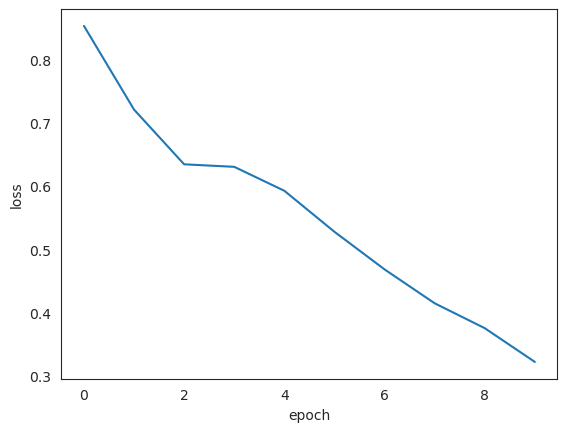

In [24]:
plt.plot(epoch_losses)
plt.gca().set_ylabel("loss")
plt.gca().set_xlabel("epoch")

In [28]:
# To save time, we'll load some pre-trained weights
load_weights = True
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("../model.h5")
    elif deepsensor.backend.str == "torch":
        model.model.load_state_dict(torch.load("../model.pt"))

In [33]:
test_date = pd.Timestamp("2014-01-01")
task = task_loader(test_date, (100, "all"))
mean_ds, std_ds = model.predict(task, X_t=era5_raw_ds)
mean_ds

<xarray.Dataset>
Dimensions:  (time: 1, y: 280, x: 280)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float32 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float32 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
Data variables:
    t2m      (time, y, x) float32 -1.246 -1.149 -1.189 ... 0.1051 0.1311 0.1034

In [30]:
err_da = mean_ds - era5_raw_ds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


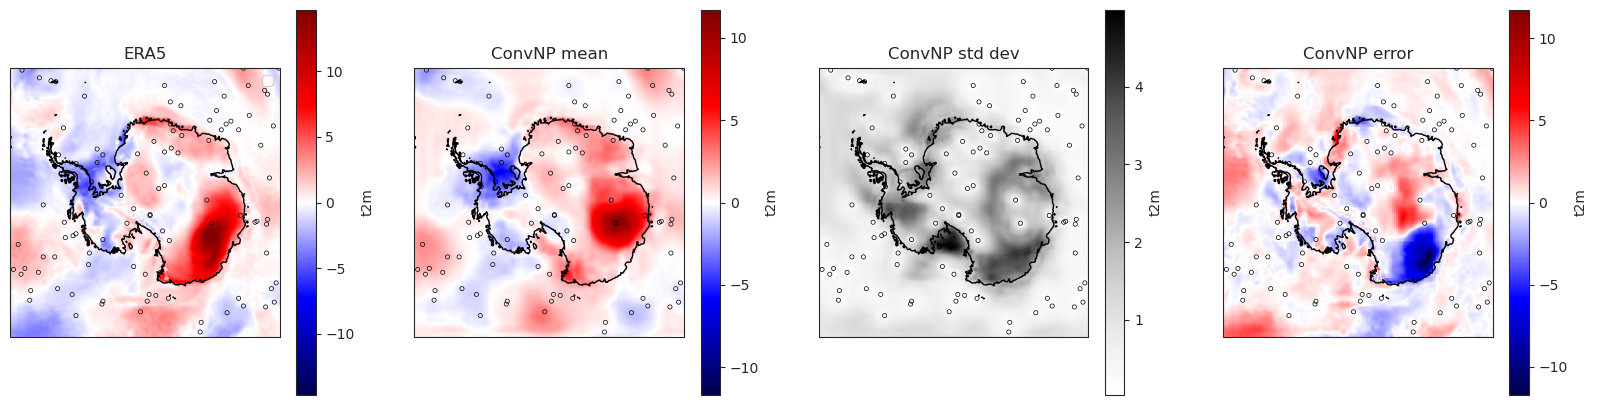

In [32]:
crs = ccrs.LambertAzimuthalEqualArea(0, -90)
fig, axes = plt.subplots(subplot_kw={"projection": crs}, nrows=1, ncols=4, figsize=(20, 5))
era5_raw_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[0])
axes[0].set_title("ERA5")
mean_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[1])
axes[1].set_title("ConvNP mean")
std_ds["t2m"].sel(time=task["time"]).plot(cmap="Greys", ax=axes[2])
axes[2].set_title("ConvNP std dev")
err_da["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[3])
axes[3].set_title("ConvNP error")
plot_offgrid_context(axes, task, data_processor, s=3**2, linewidths=0.5)
for ax in axes:
    ax.coastlines()